<a id='top'></a>

#  IBM Q Capture Jupyter Notebook
Author: Christian Lenke, IBM<br>
Version: 2019-07-23

## Table of content

* [Preface](#intro)
* [Introduction](#intro)
<p>
* [Installation, import, function definition](#preparation)
  * [Environment Definition and Customization](#customization)
  * [Get a connection to the Q Capture Server](#connect_qcap)
<p>
* [Q Capture Status overview](#overview_qcap)
  * [General Q Capture overview](#overview_qcap)
  * [Send Queue state](#sendq)
  * [Q Subscriptions by Send Queue](#qsubs_sendq)    
<p>
* [Q Capture performance graphs](#qcap_performance)
  * [Log Reader statistics](#qcap_performance)    
  * [Publisher statistics](#qcap_publ)        
<p>
* [Status details](#qcap_details)
  * [Send Queue details](#qcap_details)
  * [Q Subscription details](#qsubs_details)
  * [Q Subscription quality assurance](#qsubs_qa)        
<p>
* [Q Capture Control Tables](#qcap_cntl)
  * [CAPPARMS](#qcap_cntl)
  * [CAPMON and CAPQMON](#qcap_mon)
  * [CAPTRACE](#qcap_trace)            

[Back to Top](#top)
<a id='intro'></a>

## Preface

This Jupyter Notebook is sample code. No warranty.

## Introduction

This set of Jupyter Notebook can be used to display status, performance, and health of an IBM Q Replication setup. The following components are provided:
 <ul>
  <li>Q Capture Jupyter Notebook (this Notebook)</li>
  <li>Q Apply Jupyter Notebook</li>
  <li>Q Replication function library Jupyter Notebook</li>
  <li>A set of SQL queries in files (asnmonitor) for status calculation and quality assurance</li>    
</ul> 
The Notebooks display the content of the IBM Q Replication control tables. This includes an overall health summary for both Q Capture and Q Apply, performance graphs (throughput, latency, etc.), and control table details for both queues and subscriptions.<br>
Start with the following:<br>
 <ol>
  <li>Copy the set of SQL query files to a location in your environment</li>
  <li>Cuctomize some of the SQL files depending on your environment</li>
  <li>Customize the Q Replication function library (details explained in that Notebook)</li>
  <li>Customize the Q Capture and Q Apply Notebooks in Section "Environment Definition and Customization" 
</ol> 
To better understand the Q Replication control tables and the SQL queries used, have a look at<br>
<A HREF="https://developer.ibm.com/recipes/tutorials/q-replication-for-dbas/">Q Replication for DBAs</A>,<br> 
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrcaplist.html">Control tables at the Q Capture server</A>,<br> 
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrapplist.html">Control tables at the Q Apply server</A>, or <br>
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.db.repl.intro.doc/topics/iiyrqinfroadmap.html">Q Replication Information Roadmap (IBM Knowledge Center)</A>

[Back to Top](#top)
<a id='preparation'></a>

# Preparation

## Installation, import, function definition 

First of all the "IBM Q Replication Monitoring Jupyter Library.ipynb" is run. It imports all required libraries (SQLAlchemy, pandas, pixiedust, ...) and defines functions used in this Notebook.

In [1]:
%run "IBM Q Replication Monitoring Jupyter Library.ipynb"
from sqlalchemy import exc

Pixiedust database opened successfully


IBM Q Replication Monitoring Jupyter Library.ipynb loaded successfully


[Back to Top](#top)
<a id='customization'></a>

## Environment Definition and Customization

BEFORE YOU START define your environment here. Specify your individual values for all variables in the below cell.

In [2]:
# Define your Q Capture Schema. All queries selecting data from the Q Replication control tables 
# have been coded schemaless, the schema needs to be declared once here.
# capture_schema = 'ASN'
capture_schema = 'LSN'

# Database alias of the Q Capture Server (Db2 LUW database name or Db2 z/OS location name)
db2alias = 'ASCIIDB'

# Setting the connection variables for the Q Capture server 
# (usually the Q Replication target database)
db2_driver='ibm_db_sa'
# Host name or ip-address of the Q Capture Server
db2host  = 'localhost'
# Db2 port of the Q Capture Server (defined as char)
db2port  = 50000

# User id privileged to read the Q Capture control tables
db2user  = 'db2inst1'
# You will be prompted to type in your password
db2password = getpass.getpass('Password for database ' + db2alias + ': '); 

Password for database ASCIIDB: ········


In [3]:
# Switch to control debug messages. False: No debug messages; True: Some debug messages will be printed
# debug = True
debug = False

# Display all columns when showing a data frame
pandas.set_option('display.max_columns', None)

# Define the date range for plotting performance data from IBMQREP_CAPMON and IBMQREP_CAPQMON 
# (plots grouped by hour)
# Default: 60 (Retrieve only 60 days of Monitor data for plotting)
# If you want to retrieve all available data, set max_mon_plot_range = -1
# max_mon_plot_range = -1
max_mon_plot_range = 60

# Define the number of most recent messages messages to be retrieved from IBMQREP_CAPTRACE
# If you want to retrieve all available data, set num_messages_trace = -1
# num_messages_trace = -1
num_messages_trace = 200

# Define the date range for fetching monitor information from IBMQREP_CAPMON and IBMQREP_CAPQMON
# Default data rage in number of days, negative number, e.g. -5 (last n days of monitoring data)
default_mon_date_range = 10

# Custom range: -1 means from oldest available (start) to most recent (end).
# Alternatively, specify timestamp in Db2 format
# custom_mon_start_date  = '2018-11-02-10.00.00.000000'
custom_mon_start_date  = -1
custom_mon_end_date    = -1

In [4]:
# Check the validity of some parms
check_minus_1_or_positive_int('max_mon_plot_range', max_mon_plot_range)        
check_minus_1_or_positive_int('num_messages_trace', num_messages_trace)        
check_positive_int('default_mon_date_range', default_mon_date_range) 

INFO: max_mon_plot_range checked ok
INFO: num_messages_trace checked ok
INFO: default_mon_date_range checked ok


[Back to Top](#top)
<a id='connect_qcap'></a>

## Get a connection to the Q Capture Server

In [5]:
# Getting a connection to the Q Capture server. 

try:
    db2con = connect_to_db2(db2_driver, db2user, db2password, db2host, str(db2port), db2alias)
except exc.SQLAlchemyError as ex:
    print('There is a database connection pool problem.........DB-Name= ' + db2alias)
    sys.exit(1)

try:
    print('INFO: Get database connect from pool: ' + db2alias)
    connection = db2con.connect()
except exc.SQLAlchemyError as ex:
    print('There is a database connection problem.........DB-Name= ' + db2alias)
    print(ex)
    sys.exit(1)

INFO: Get database connect from pool: ASCIIDB


Set the CURRENT SCHEMA to the CAPTURE SCHEMA. All queries executed thereafter are schemaless

In [6]:
# For the connection the SCHEMA is set to the Q Capture schema
connection.execute("SET CURRENT SCHEMA = '" + capture_schema + "'")

print("INFO: CURRENT SCHEMA = '" + capture_schema + "'")

INFO: CURRENT SCHEMA = 'LSN'


[Back to Top](#top)
<a id='overview_qcap'></a>

# Q Capture Status overview

## General status overview

The first query displays the overall status of the Q Capture Server. The result set displays messages of the following types:
 <ul>
  <li>C-LAT: Is Q Capture running or not / is the latency as expected (threshold needs to be set in 'qrep_monitor_capture.sql')</li>
    <ul>    
        <li>ERROR: Q Capture not running or latency error threshold exceeded</li>
        <li>WARNING: Q Capture latency warning threshold exceeded</li>
        <li>INFO: Q Capture up and running and latency threshold ok</li>        
    </ul>            
  <li>C-SQU: Send queue status, displayed for each send queue.</li>
    <ul>    
        <li>ERROR: Send Queue inactive due to an error</li>
        <li>INFO: Send Queue active</li>            
    </ul>                    
  <li>S-SUB: Summary whether all subscriptions for a queue are active or not, displayed for each send queue.</li>
</ul> 

In [7]:
# The function get_capture_status executes the query 'qrep_monitor_capture.sql' 
# (with language dependent result set) and returns a pandas data frame
df_capstate = get_capture_status(connection)

# drop column 'CURRENT_SERVER'
df_capstate.drop(df_capstate.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_capstate = (df_capstate.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_capstate

,check_ts,PROGRAM,mtyp,sev,mtxt
0,2019-12-03 13:33:07.415000,ASNQCAP(LSN),C-LAT,ERROR,Q Capture not running / interrupted since 2019-11-27-10.50.59.513000.
1,2019-12-03 13:33:07.415000,ASNQCAP(LSN),C-SQU,INFO,Send Queue LSN.ASCIIDB.BLU_TGT.SENDRECVQ active. (#subs A/I/N/O: 6/1/0/0). XMITQDEPTH=1.
2,2019-12-03 13:33:07.415000,ASNQCAP(LSN),C-SQU,INFO,Send Queue LSN.ASCIIDB.TARGETDB.SENDRECVQ active. (#subs A/I/N/O: 14/1/0/0). XMITQDEPTH=1.
3,2019-12-03 13:33:07.415000,ASNQCAP(LSN),C-SUB,WARNING,1 of 15 subscriptions for SENDQ LSN.ASCIIDB.TARGETDB.SENDRECVQ inactive. Among those new (N): 0
4,2019-12-03 13:33:07.415000,ASNQCAP(LSN),C-SUB,WARNING,1 of 7 subscriptions for SENDQ LSN.ASCIIDB.BLU_TGT.SENDRECVQ inactive. Among those new (N): 0


[Back to Top](#top)
<a id='sendq'></a>

### Overall send queue state

Number of active send queues (green) vs. number of inactive send queues (red)

Text(0, 0.5, '')

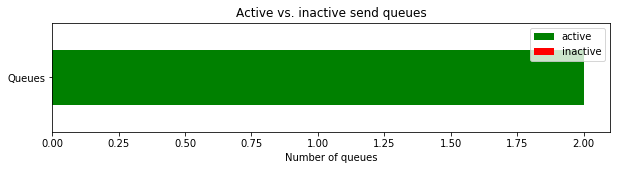

In [8]:
# The function get_sendq_state executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_qstate = get_sendq_state(connection)  

df_qstate.set_index('queues',inplace=True)

qpl = df_qstate.plot.barh(stacked=True,color=['green', 'red'], 
                          title="Active vs. inactive send queues",
                          figsize=(10,2))

qpl.set_xlabel("Number of queues")
qpl.set_ylabel("")

[Back to Top](#top)
<a id='qsubs_sendq'></a>

## Subscription STATE by send queue

Number of active subscriptions (green) vs. number of inactive subscriptions (red) per send queue

Text(0, 0.5, '')

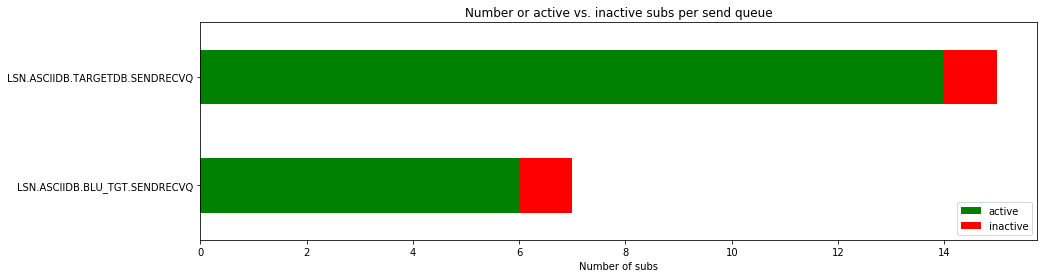

In [9]:
# The function get_substate_by_recvq executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_q = get_substate_by_sendq(connection)

numqs = len(df_q.sendq.unique())
if numqs >=20:
    calc_fig_height = numqs / 2
if numqs <=2:
    calc_fig_height = numqs * 2
else:
    calc_fig_height =  numqs

# NEXT: Adding labels (SENDQ) - does not work
df_q.set_index('sendq',inplace=True) 

sqpl = df_q.plot.barh(stacked=True,color=['green', 'red'],
                       title="Number or active vs. inactive subs per send queue",
                       figsize=(15,calc_fig_height))

sqpl.set_xlabel("Number of subs")
sqpl.set_ylabel("")

[Back to Top](#top)
<a id='qcap_performance'></a>

# Q Capture Performance Graphs

## Capture Log Reader statistics per hour (rows_processed, current_memory, trans_spilled)

In [10]:
# The function get_perf_logrd executes a query which selects data from IBMQREP_CAPMON
# and returns a pandas data frame. The CAPMON data is GROUPed BY hour(monitor_time)
# by the query. In case max_mon_plot_range == 0, the query will retrieve all available data 
# from CAPMON. If max_mon_plot_range > 0, the CAPMON data will be limited to the recent
# max_mon_plot_range days

if max_mon_plot_range == -1:              
    print('INFO: Evaluating all available CAPMON data') 
else:   
    print('INFO: Limiting the CAPMON data to ' + str(max_mon_plot_range) + ' days.')
    
capmon_logrd = get_perf_logrd(connection, max_mon_plot_range)

INFO: Limiting the CAPMON data to 60 days.


In [11]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(capmon_logrd)

In [12]:
# Todo: What if data fame is empty (test)

# Determine the date of max(monitor_time). This is used when only a subset (e.g., most recent
# 5 days of data) is displayed later. Could be that the Notebook is used to evaluate saved 
# CAPMON data, so that today() - n days would have no data. 
maxmontime = capmon_logrd['monitor_date'].max()
maxmondate = datetime.strptime(maxmontime[:10], "%Y-%m-%d")

if debug:
   print('DEBUG: maxmondate=' + str(maxmondate))

All available data from IBMQREP_CAPMON (max. <i>max_mon_plot_range</i> days)

INFO: Plotting range: 2019-11-27 - 60 days


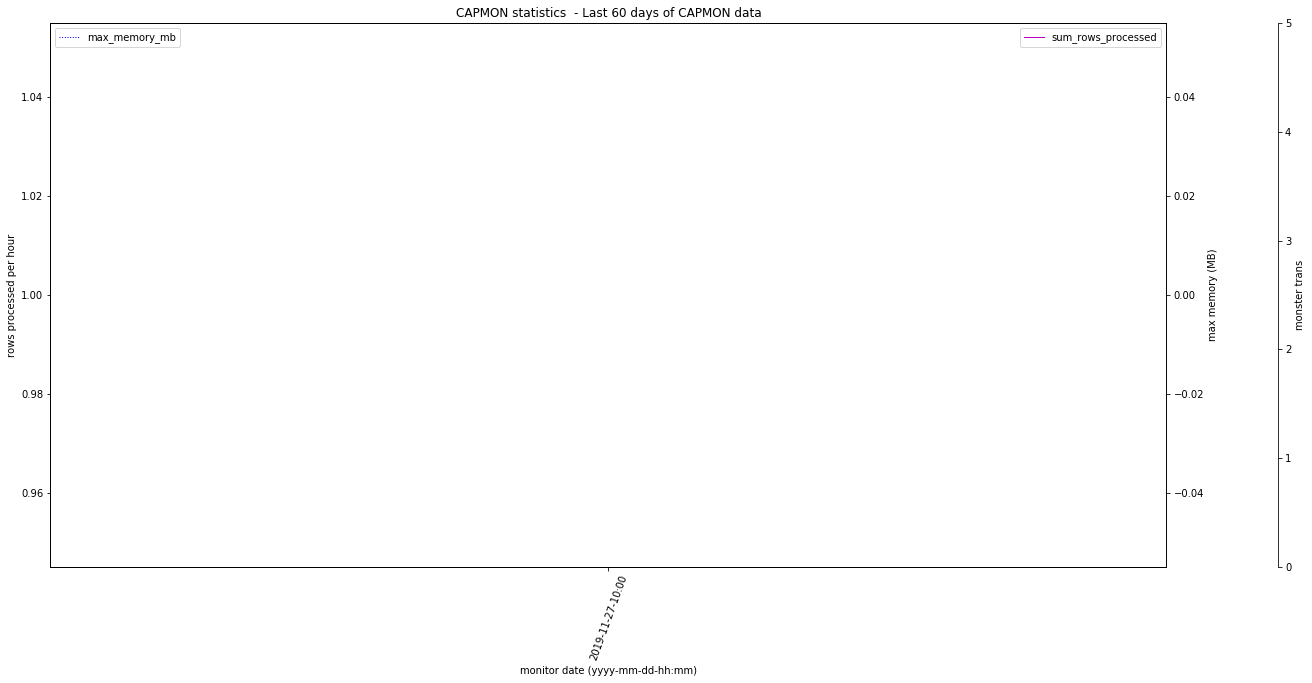

In [13]:
# Plot figure with all available data   

# deltadays = 0 means all available data of the data frame
deltadays = max_mon_plot_range

if deltadays == -1:
    print('INFO: Plotting range: All data up to ' + maxmondate.strftime("%Y-%m-%d"))
else:
    print('INFO: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
    
# The function plot_capmon creates a figure with 1 plot from the 
# data frame capmon_lat
capmon_plt1 = plot_capmon(capmon_logrd,deltadays)
capmon_plt1.show()  

Recent 20 days from IBMQREP_CAPMON

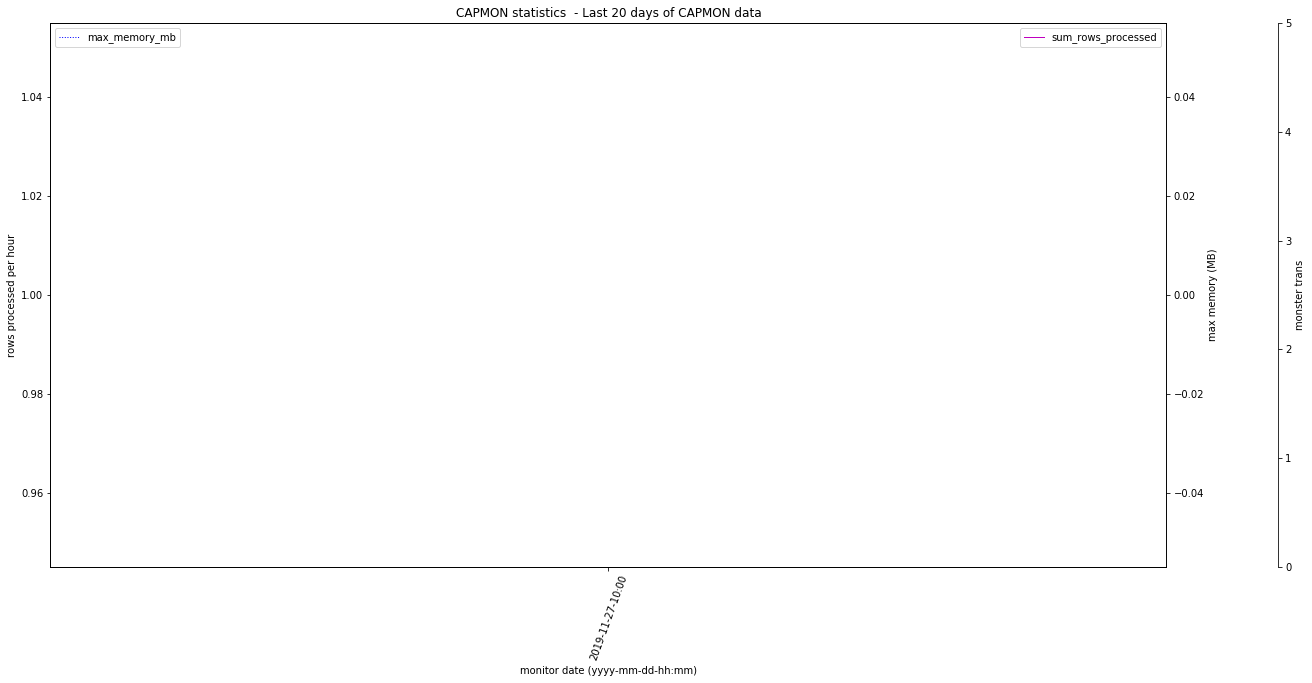

In [14]:
# Zoom in - Same figure as above, with data of the last 20 days only (maxmondate - 20 days)

# display 20 days of data only
deltadays = 20
# old: date_20_days_ago = date.today() - timedelta(days=deltadays)
date_20_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_20_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range 
#   - reset_index was introduced to guarantee xticks in the plot
capmon_logrd_20 = capmon_logrd[capmon_logrd.monitor_date 
                               >= date_20_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)  

capmon_plt2 = plot_capmon(capmon_logrd_20,deltadays)
capmon_plt2.show()        

Recent 5 days from IBMQREP_CAPMON

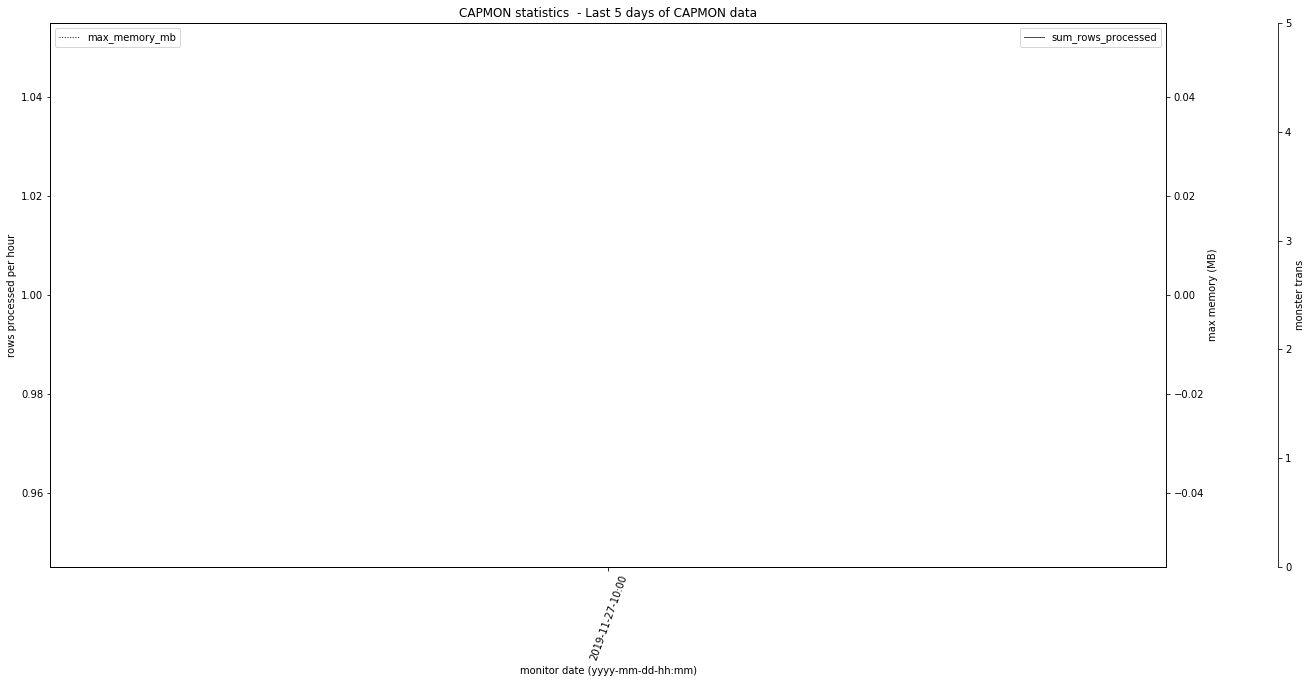

In [15]:
# Zoom in - Same figure as above, with data of the last 5 days only (maxmondate - 5 days)

# display 5 days of data only
deltadays = 5

# old: date_5_days_ago = date.today() - timedelta(days=deltadays)
date_5_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_5_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range 
#   - reset_index was introduced to guarantee xticks in the plot
capmon_logrd_5 = capmon_logrd[capmon_logrd.monitor_date 
                              >= date_5_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)  

capmon_plt3 = plot_capmon(capmon_logrd_5,deltadays)
capmon_plt3.show()   

[Back to Top](#top)
<a id='qcap_publ'></a>

## Capture Publisher statistics per hour (rows_processed, mq_messages ,xmitqdepth)

In [16]:
# The function get_perf_logrd executes a query which selects data from IBMQREP_CAPMON
# and returns a pandas data frame. The CAPMON data is GROUPed BY hour(monitor_time)
# by the query. In case max_mon_plot_range == 0, the query will retrieve all available data 
# from CAPQMON. If max_mon_plot_range > 0, the CAPQMON data will be limited to the recent
# max_mon_plot_range days

if max_mon_plot_range == -1:              
    print('INFO: Evaluating all available CAPQMON data') 
else:   
    print('INFO: Limiting the CAPQMON data to ' + str(max_mon_plot_range) + ' days.')

capqmon_publ = get_perf_publ(connection,max_mon_plot_range)

INFO: Limiting the CAPQMON data to 60 days.


In [17]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(capqmon_publ)

In [18]:
# Todo: What if data fame is empty (test)

# Determine the date of max(monitor_time). This is used when only a subset (e.g., most recent
# 5 days of data) is displayed later. Could be that the Notebook is used to evaluate saved 
# APPLYMON data, so that today() - n days would have no data. 
maxmontime = capqmon_publ['monitor_date'].max()
maxmondate = datetime.strptime(maxmontime[:10], "%Y-%m-%d")

if debug:
    print('DEBUG: maxmondate=' + str(maxmondate))
    print()

# Determination of the number of distinct receive queues in the result set
numqs = len(capqmon_publ.sendq.unique())

print('INFO: numqs=' + str(numqs))

# DEBUG - print the distinct names of the queues
if debug:    
   for i in range(0,numqs):
       print('DEBUG: ' + capqmon_publ.sendq.unique()[i])

INFO: numqs=2


All available data from IBMQREP_CAPQMON (max. <i>max_mon_plot_range</i> days)

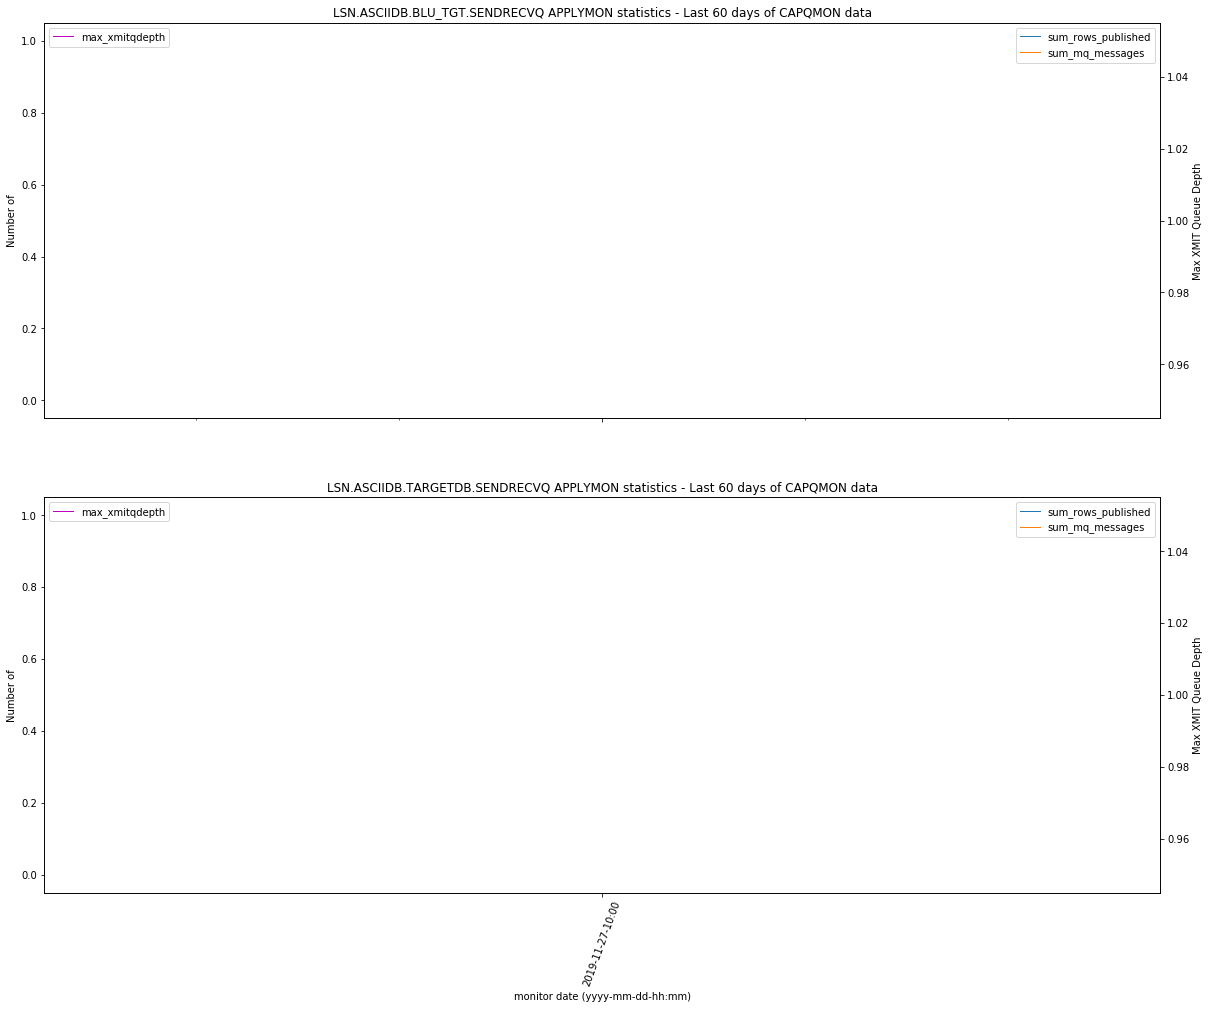

In [19]:
# Plot figure (one plot per queue) with all available data   

# deltadays = 0 means all available data of the data frame
deltadays = max_mon_plot_range

if debug:
    print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')

# The function plot_capmon creates a figure with n plots (n = number of queues) from the 
# data frame capqmon_lat
# The hight of the following figures (calculated in plot_capqmon) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
capqmon_plt1 = plot_capqmon(capqmon_publ,numqs,deltadays)
capqmon_plt1.show() 

Recent 20 days from IBMQREP_CAPQMON

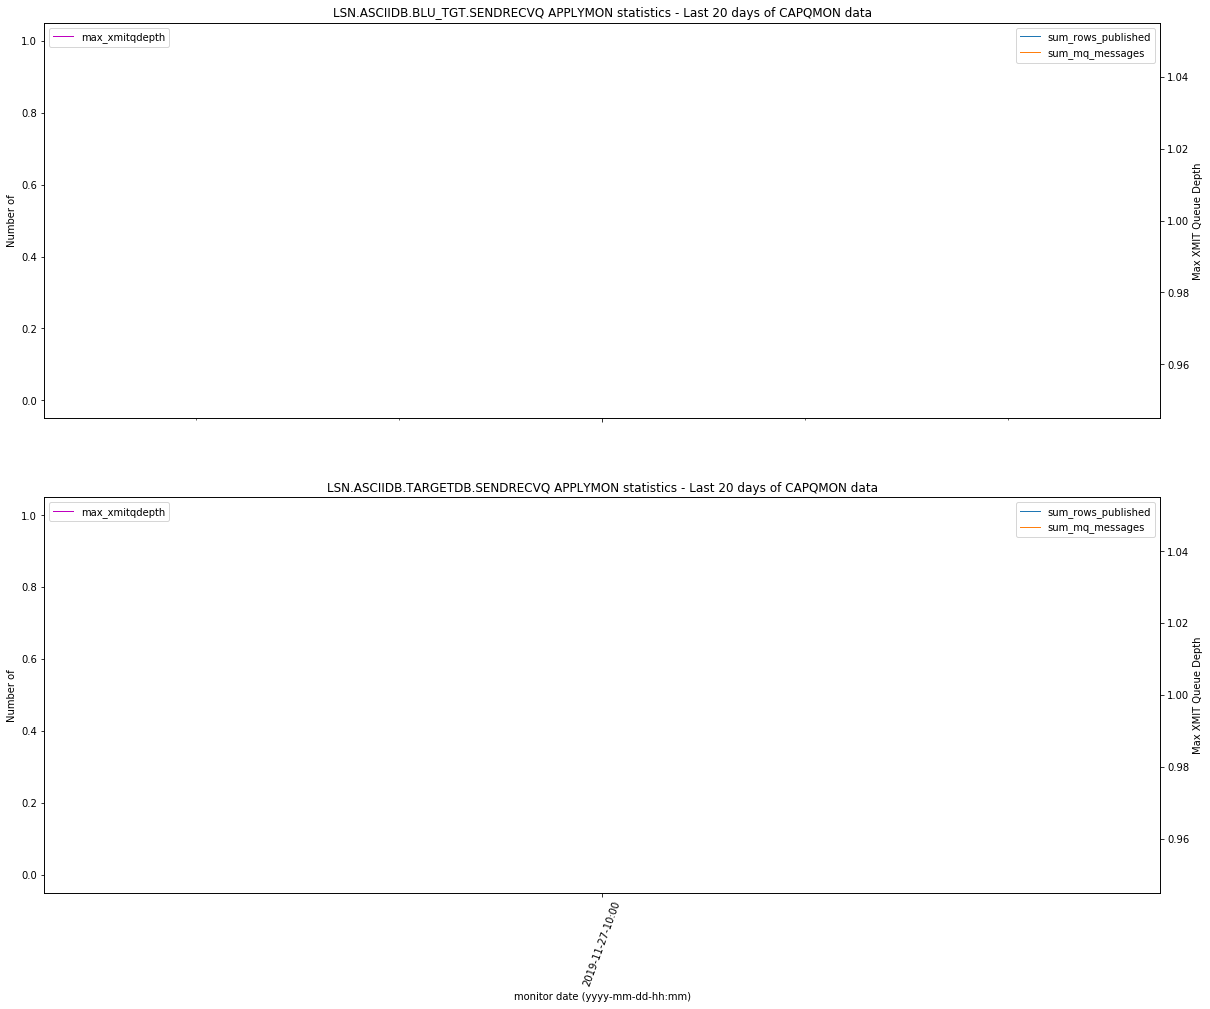

In [20]:
# Zoom in - Same figure as above, with data of the last 20 days only (maxmondate - 20 days)

# display 20 days of data only
deltadays = 20
# old: date_20_days_ago = date.today() - timedelta(days=deltadays)
date_20_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_20_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range
#   - reset_index was introduced to guarantee xticks in the plot
capqmon_publ_20 = capqmon_publ[capqmon_publ.monitor_date 
                               >= date_20_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(capqmon_publ_20.sendq.unique())

if numqs == 0:
    # Data frame could be empty
    print('No data available to display with MONITOR_TIME > ' + date_20_days_ago.strftime("%Y-%m-%d"))
else:
    capqmon_plt2 = plot_capqmon(capqmon_publ_20,numqs,deltadays)
    capqmon_plt2.show()        

Recent 5 days from IBMQREP_CAPQMON

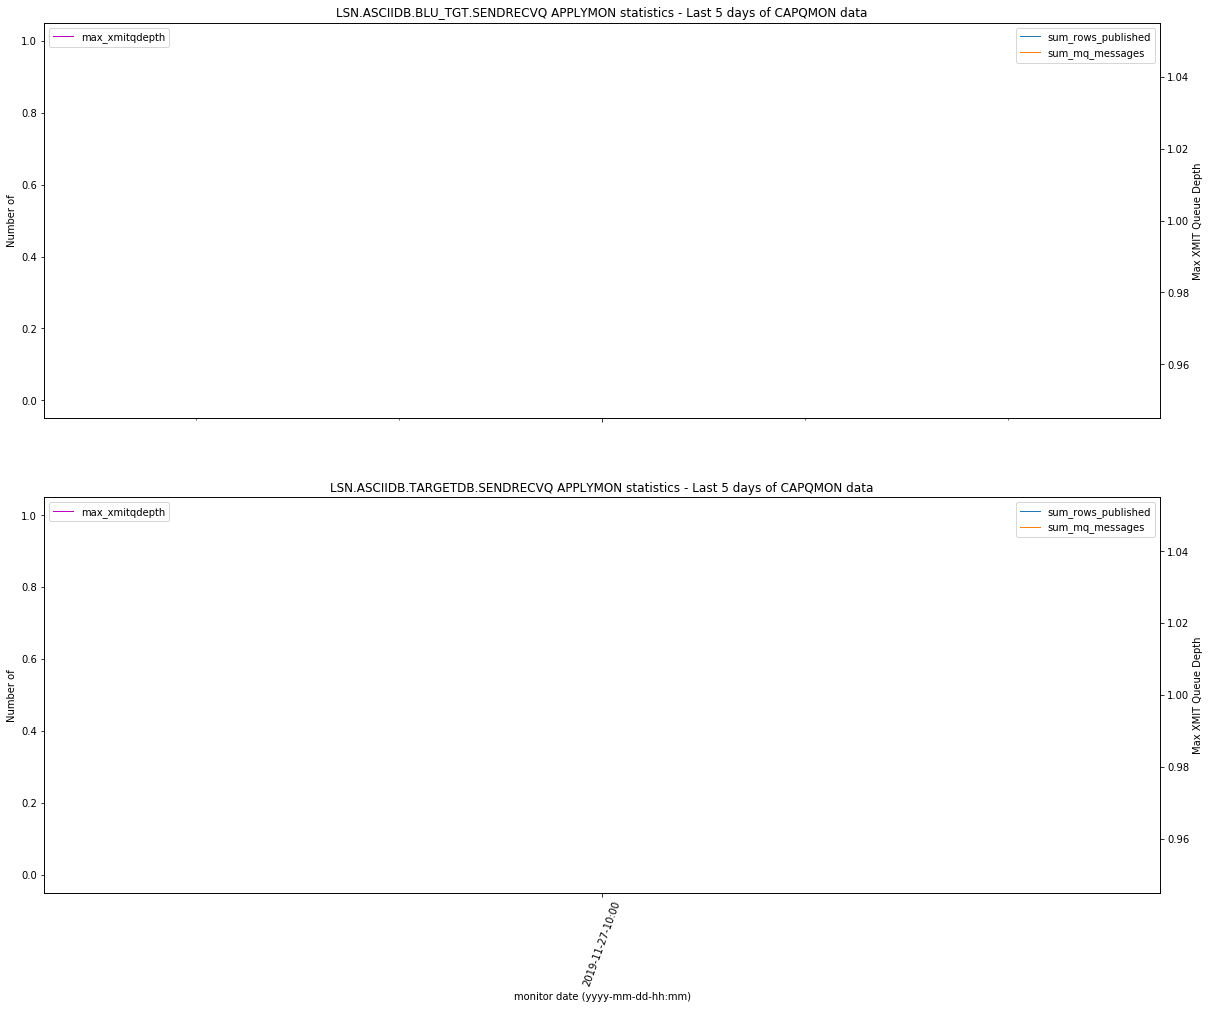

In [21]:
# Zoom in - Same figure as above, with data of the last 5 days only (maxmondate - 5 days)

# display 5 days of data only
deltadays = 5

# old: date_5_days_ago = date.today() - timedelta(days=deltadays)
date_5_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_20_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range 
#   - reset_index was introduced to guarantee xticks in the plot
capqmon_publ_5 = capqmon_publ[capqmon_publ.monitor_date 
                              >= date_5_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(capqmon_publ_5.sendq.unique())

if numqs == 0:
    # Data frame could be empty
    print('No data available to display with MONITOR_TIME > ' + date_5_days_ago.strftime("%Y-%m-%d"))
else:    
    capqmon_plt3 = plot_capqmon(capqmon_publ_5,numqs,deltadays)
    capqmon_plt3.show()    

[Back to Top](#top)
<a id='qcap_details'></a>

# Q Capture details

## Send Queue details

Send queue details (IBMQREP_SENDQUEUES)

In [22]:
# The function get_sendq_details executes a query which selects detail data from IBMQREP_SENDQUEUES
# and returns a pandas data frame
df_queues = get_sendq_details(connection, capture_schema)

# set index does not work
df_queues.set_index(['sendq'],inplace=True)
df_queues.sort_values(['sendq'], ascending=[True], inplace=True)

# printing the data frame
df_queues

,pubqmapname,recvq,message_format,msg_content_type,state,state_time,state_info,error_action,heartbeat_interval,max_message_size,apply_server,apply_alias,apply_schema,description,message_codepage,column_delimiter,string_delimiter,record_delimiter,decimal_point,sendraw_iferror,lob_too_big_action,xml_too_big_action,num_parallel_sendqs,mcgname,has_filesend,apply_level
sendq,,,,,,,,,,,,,,,,,,,,,,,,,,
LSN.ASCIIDB.BLU_TGT.SENDRECVQ,ASCIIDB_LSN_TO_BLU_TGT_LSN,LSN.ASCIIDB.BLU_TGT.SENDRECVQ,C,T,A,2019-11-27 10:50:03.298,None,S,60000,64,BLU_TGT,BLU_TGT,LSN,,None,None,None,None,None,N,Q,Q,1,None,N,1140.101
LSN.ASCIIDB.TARGETDB.SENDRECVQ,ASCIIDB_LSN_TO_TARGETDB_LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,C,T,A,2019-11-27 10:50:03.293,None,S,60000,64,TARGETDB,TARGETDB,LSN,,None,None,None,None,None,N,Q,Q,1,None,N,1140.101


[Back to Top](#top)
<a id='qsubs_details'></a>

## Subscription details

Subscription details (IBMQREP_SUBS). Use pixiedust options to filter the result set or to convert the table into a  graph.

In [ ]:
# The function get_subs_details executes a query which selects detail data from IBMQREP_SUBS
# and returns a pandas data frame
df_subs = get_subs_details(connection, capture_schema)

#df_subs.set_index('subname',inplace=True)
df_subs.sort_values(['subname'], ascending=[True], inplace=True)    

# displaying the data frame using pixiedust
display(df_subs)

subname,source_owner,source_name,target_server,target_alias,target_owner,target_name,target_type,apply_schema,sendq,search_condition,sub_id,subtype,all_changed_rows,before_values,changed_cols_only,has_loadphase,state,state_time,state_info,state_transition,subgroup,source_node,target_node,group_members,options_flag,suppress_deletes,description,topic,capture_load,change_condition,igncasdel,igntrig,logrd_error_action,repl_addcol,ignsetnull,capture_truncate,sub_creator,schema_subname
CODEPAGE_EXPAND_FACTOR_11144_UCOPY,DE094692,CODEPAGE_EXPAND_FACTOR_11144,TARGETDB,TARGETDB,DE094692,CODEPAGE_EXPAND_FACTOR_11144_UCOPY,1,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,20,U,N,N,Y,I,A,2019-02-07 13:57:52.161000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,Y,N,W,asnclp,None
CODEPAGE_EXPAND_FACTOR_CCD,DE094692,CODEPAGE_EXPAND_FACTOR,TARGETDB,TARGETDB,DE094692,CODEPAGE_EXPAND_FACTOR_CCD,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,18,U,N,N,N,N,A,2018-03-26 11:38:53.344000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,Y,N,W,asnclp,None
CODEPAGE_EXPAND_FACTOR_UCOPY,DE094692,CODEPAGE_EXPAND_FACTOR,TARGETDB,TARGETDB,DE094692,CODEPAGE_EXPAND_FACTOR_UCOPY,1,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,17,U,N,N,Y,I,A,2018-03-26 11:38:53.344000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,Y,N,W,asnclp,None
EMPLOYEE0002,USER01,EMPLOYEE,BLU_TGT,BLU_TGT,ASCIIDB,EMPLOYEE_CCD,2,LSN,LSN.ASCIIDB.BLU_TGT.SENDRECVQ,None,2,U,N,Y,N,N,I,2018-10-30 17:28:21.486000,ASN7006E,None,None,0,0,None,NNNN,N,None,None,W,None,N,N,D,Y,N,R,None,None
EXPRESSION_TRG_COLS_CHAR_KEY_CCD,DE094692,EXPRESSION_TRG_COLS_CHAR_KEY,TARGETDB,TARGETDB,DE094692,EXPRESSION_TRG_COLS_CHAR_KEY_CCD,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,14,U,N,N,N,N,A,2017-09-05 16:34:43.407000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,asnclp,None
EXPRESSION_TRG_COLS_INT_KEY_CCD,DE094692,EXPRESSION_TRG_COLS_INT_KEY,TARGETDB,TARGETDB,DE094692,EXPRESSION_TRG_COLS_INT_KEY_CCD,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,13,U,N,N,N,N,A,2017-09-05 16:34:39.879000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,asnclp,None
EXPRESSION_TRG_COLS_MIXED_KEY_CCD,DE094692,EXPRESSION_TRG_COLS_MIXED_KEY,TARGETDB,TARGETDB,DE094692,EXPRESSION_TRG_COLS_MIXED_KEY_CCD,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,15,U,N,N,N,N,A,2017-09-05 16:34:46.948000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,asnclp,None
KEYCHECK_TAB_10001,CHRISLE,KEYCHECK_TAB_1,TARGETDB,TARGETDB,CHRISLE,KEYCHECK_TAB_1,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,21,U,N,N,N,N,A,2019-07-02 15:02:17.579000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,None,None
KEYCHECK_TAB_20001,CHRISLE,KEYCHECK_TAB_2,TARGETDB,TARGETDB,CHRISLE,KEYCHECK_TAB_2,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,22,U,N,N,N,N,A,2019-06-26 08:48:12.988000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,None,None
KEYCHECK_TAB_30001,CHRISLE,KEYCHECK_TAB_3,TARGETDB,TARGETDB,CHRISLE,KEYCHECK_TAB_3,2,LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,None,23,U,N,N,N,N,A,2019-06-26 08:48:12.988000,ASN7010I,None,None,0,0,None,NENN,N,None,None,W,None,N,N,D,N,N,W,None,None


[Back to Top](#top)
<a id='qsubs_qa'></a>

## Subscription quality assurance

Runtime error prevention for existing subscriptions. The following potential error situations are reported:
 <ul>
  <li>C-TNF - Source table not found</li>
  <li>C-CNF - Subscribed column does not exist in DB2</li>
  <li>C-CNS - Existing source column not subscribed</li>
  <li>C-DCC - Data capture flag missing for source table</li>    
</ul> 

In [24]:
# The function get_capture_anomylies executes the query 'qrep_check_subs_capture.sql' 
# (with language dependent result set) and returns a pandas data frame
df_capqa = get_capture_anomylies(connection)

df_capqa.drop(df_capqa.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_capqa = (df_capqa.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_capqa

,check_ts,PROGRAM,mtyp,sev,mtxt,fixit
0,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_2_VARCHAR_400 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_2_VARCHAR_400
1,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_CHAR but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_CHAR
2,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_CHAR_10 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_CHAR_10
3,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_CHAR_200 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_CHAR_200
4,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_CHAR_200_2 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_CHAR_200_2
5,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_CHAR_50 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_CHAR_50
6,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_VARCHAR_10 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_VARCHAR_10
7,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.NEWCOL_VARCHAR_400 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN NEWCOL_VARCHAR_400
8,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.VARCHAR_20000 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN VARCHAR_20000
9,2019-12-03 13:33:16.735000,ASNQCAP(LSN),C-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains source column DE094692.CODEPAGE_EXPAND_FACTOR.VARCHAR_TARGET_300 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR ADD COLUMN VARCHAR_TARGET_300


[Back to Top](#top)
<a id='qcap_cntl'></a>

# Q Capture Control Tables

## Q Capture parameters

Stored Q Capture parameters (IBMQREP_CAPPARMS)

In [25]:
# The function get_capparms executes a query which selects detail data from IBMQREP_CAPPARMS
# and returns a pandas data frame
df_capparms = get_capparms(connection, capture_schema)

# printing the data frame
df_capparms

,qmgr,remote_src_server,restartq,adminq,startmode,memory_limit,commit_interval,autostop,monitor_interval,monitor_limit,trace_limit,signal_limit,prune_interval,sleep_interval,logreuse,logstdout,term,capture_path,arch_level,compatibility,lob_send_option,qfull_num_retries,qfull_retry_delay,msg_persistence,logrdbufsz,capture_alias,stale,warnlogapi,trans_batch_sz,part_hist_limit,startallq,nmi_enable,nmi_socket_name,warntxsz,logspooling,max_trans,reprocess_signals,log_commit_interval,trans_batch_info,in_mem_filter_eval,use_capcmd_table,capcmd_interval,max_capstarts_intload,mqthread_bufsz,parallel_mqthread,possible_level,current_level,control_tables_level,remote_source_db_loc,on_remote_source_unavail
0,LSN,None,LSN.ASCIIDB.RESTARTQ,LSN.ASCIIDB.ADMINQ,WARMSI,500,500,N,30000,100000,10080,10080,300,500,N,N,Y,None,1140,1140,I,30,250,Y,512,ASCIIDB,3600,0,40,10080,Y,N,None,0,N,200,N,30,N,Y,N,3000,0,4096,N,1140.101,1140.101,1140.101,None,W


[Back to Top](#top)
<a id='qcap_mon'></a>

## Q Capture CAPMON and CAPQMON

In [26]:
# Calculate the monitoring date range
# - as lowest date:
#      - in case custom_mon_start_date == -1 take current date - daterange days, otherweise custom_mon_start_date
# - as highest date:
#      - in case custom_mon_end_date == -1 take current date, otherweise custom_mon_start_date

calc_mon_dates = calc_mon_start_end(custom_mon_start_date, custom_mon_end_date, default_mon_date_range)

mon_start_date = calc_mon_dates[0]
mon_end_date   = calc_mon_dates[1]

# Debug
if debug:
    print("Monitor Start Date: " + mon_start_date)
    print("Monitor End Date:   " + mon_end_date)

In [ ]:
# The function get_capmon executes a query which selects detail data from IBMQREP_CAPMON
# and returns a pandas data frame
df_capmon = get_capmon(connection, capture_schema, mon_start_date, mon_end_date)

df_capmon.set_index('monitor_time')

# sort does not seem to work
df_capmon.sort_values(['monitor_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_capmon)

monitor_time,current_log_time,capture_idle,current_memory,rows_processed,trans_skipped,trans_processed,trans_spilled,max_trans_size,queues_in_error,restart_seq,current_seq,last_eol_time,logread_api_time,num_logread_calls,num_end_of_logs,logrdr_sleeptime,restart_maxcmtseq,mqcmit_time,num_logread_f_calls,trans_queued,num_warntxs,num_warnlogapi,parallel_publish_wait,num_mqcmits,num_logread_no_prog,num_logread_errors,num_stmtfiles
2019-11-27 10:50:59.513000,1900-01-01 00:00:00,26482,0,0,0,0,0,0,0,000000000025E96D0000000001A95C00,000000000025E96D0000000001A95C00,2019-11-27 10:50:58.851000,707,51,51,25500,00000000002209B000000000019C1334,9,0,1,0,0,None,None,None,None,0
2019-11-27 10:50:33.279000,1900-01-01 00:00:00,29070,0,1,0,0,0,0,0,000000000025E9690000000001A95BF2,000000000025E9690000000001A95BF2,2019-11-27 10:50:32.832000,2225,55,54,26500,00000000002209B000000000019C1334,7,0,0,0,0,None,None,None,None,0


In [28]:
# The function get_capqmon executes a query which selects detail data from IBMQREP_CAPQMON
# and returns a pandas data frame
df_capqmon = get_capqmon(connection, capture_schema, mon_start_date, mon_end_date)

# sort does not seem to work
df_capqmon.sort_values(['monitor_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_capqmon)

monitor_time,sendq,rows_published,trans_published,chg_rows_skipped,delrows_suppressed,rows_skipped,qfull_error_count,lobs_too_big,xmldocs_too_big,mq_bytes,mq_messages,current_seq,restart_seq,restart_maxcmtseq,mqput_time,xmitqdepth,trans_streaming,trans_stream_begin,trans_stream_commit,trans_stream_rollback,stream_chunks_published
2019-11-27 10:50:59.522000,LSN.ASCIIDB.BLU_TGT.SENDRECVQ,0,0,0,0,0,0,0,0,0,0,000000000025E96D0000000001A95C00,000000000025E96D0000000001A95C00,00000000002209B000000000019C1334,0,1,0,0,0,0,0
2019-11-27 10:50:59.521000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,0,0,0,0,0,0,0,0,0,0,000000000025E96D0000000001A95C00,000000000025E96D0000000001A95C00,00000000002209B000000000019C1334,0,1,0,0,0,0,0
2019-11-27 10:50:33.289000,LSN.ASCIIDB.BLU_TGT.SENDRECVQ,0,0,0,0,0,0,0,0,676,1,000000000025E9690000000001A95BF2,000000000025E9690000000001A95BF2,00000000002209B000000000019C1334,2,1,0,0,0,0,0
2019-11-27 10:50:33.287000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,0,0,0,0,0,0,0,0,676,1,000000000025E9690000000001A95BF2,000000000025E9690000000001A95BF2,00000000002209B000000000019C1334,2,1,0,0,0,0,0


[Back to Top](#top)
<a id='qcap_trace'></a>

## Q Capture message log

Displaying the n (num_messages) most recent runtime log messages from IBMQREP_CAPTRACE 

In [29]:
# The function get_captrace executes a query which selects detail data from IBMQREP_APPLYTRACE
# and returns a pandas data frame
df_captrace = get_captrace(connection, capture_schema, num_messages_trace)

# sort does not seem to work
df_captrace.sort_values(['trace_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_captrace)

operation,trace_time,description,reason_code,mq_code
INFO,2019-11-27 10:51:01.012000,"ASN0573I ""Q Capture"" : ""LSN"" : ""Initial"" : The program stopped. Reason: ""normal termination""",None,nan
INFO,2019-11-27 10:50:59.632000,"ASN7156I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : The Q Capture program stopped processing log records in log file ""C:\DB2\NODE0000\SQL00004\LOGSTREAM0000\S0001658.LOG"".",None,nan
INFO,2019-11-27 10:50:59.524000,"ASN7109I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : At program termination, the lowest log sequence number of a transaction still to be committed (LSN) is ""0000:0000:0025:E96D:0000:0000:01A9:5C00"" and the highest log sequence number of a successfully processed transaction (MAXCMTSEQ) is ""0000:0000:0022:09B0:0000:0000:019C:1334"".",None,nan
INFO,2019-11-27 10:50:58.152000,"ASN0589I ""Q Capture"" : ""LSN"" : """" The program received return code ""602"" from routine ""findRcvyMgr"".",None,nan
INFO,2019-11-27 10:50:58.148000,"ASN0589I ""Q Capture"" : ""LSN"" : """" The program received return code ""602"" from routine ""findThread"".",None,nan
INFO,2019-11-27 10:50:03.767000,"ASN0572I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : The ""mqpub 11.4.0 (Build 11.5.0.1077 Level s1906101300, PTF DYN1906101300WIN64), DB2 v11.5.0"" program initialized successfully.",None,nan
INFO,2019-11-27 10:50:03.761000,"ASN7000I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : ""20"" subscriptions are active. ""2"" subscriptions are inactive. ""0"" subscriptions that were new and were successfully activated. ""0"" subscriptions that were new could not be activated and are now inactive.",None,nan
INFO,2019-11-27 10:50:03.664000,"ASN7155I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : The Q Capture program started processing log records in log file ""C:\DB2\NODE0000\SQL00004\LOGSTREAM0000\S0001585.LOG"".",None,nan
INFO,2019-11-27 10:50:03.347000,"ASN7108I ""Q Capture"" : ""LSN"" : ""WorkerThread"" : At program initialization, the lowest log sequence number of a transaction still to be committed (LSN) is ""0000:0000:0022:78CF:0000:0000:019D:C88E"" and the highest log sequence number of a successfully processed transaction (MAXCMTSEQ) is ""0000:0000:0022:09B0:0000:0000:019C:1334"".",None,nan
INFO,2019-11-27 10:50:03.275000,"ASN7329I ""Q Capture"" : ""LSN"" : ""AdminThread"" : The value of apply_level for send queue ""LSN.ASCIIDB.BLU_TGT.SENDRECVQ"" was modified. Replication queue map: ""ASCIIDB_LSN_TO_BLU_TGT_LSN"". New apply_level: ""1140.101"".",None,nan


[Back to Top](#top)
<a id='end'></a>

Done.

## Release Notes

<b>08.05.2019:</b> This is the initial release of the Jupyter Notebook for Q Capture monitoring. It is the beginning of a learning curve and uses various Python and Jupyter Notebook techniques such as:
 <ul>    
   <li>Db2 Python libraries</li>
   <li>Pandas data frames</li>
   <li>Pixiedust for result set visualization</li>
   <li>matplotlib for the graphical representation of performance statistics</li>
 </ul>    
<b>12.07.2019:</b> Fixed not displayed xticks for plots with limited date ranges (20 days, 5 days) by resetting the index after filtering the data frame (<i>.reset_index(drop=True)</i>)<p>
<b>02.12.2019:</b> Some queries (e.g., 'get_sendq_details') just retrieve the content of IBMQREP control tables. Previously, these SQL queries contained a list of columns (all columns). This was changed for multiple queries to first generate the list of columns from the Db2 catalog and then build and execute the query. This increases the robustness of the Notebook because with that feature it supports multiple control table architecture levels (prevents errors because of missing (optional) columns).

## Feedback

Feedback and ideas for improvement are welcome and can be sent to clenke@de.ibm.com